# Обработка и классификация текстовых документов

## Описание

В этом проекте я занимаюсь обработкой текстовых документов, преобразованием их в векторные представления (эмбеддинги), кластеризацией и классификацией новых документов на основе ближайшего кластера.

## Этапы выполнения

### 1. Чтение и предобработка текстов

- Я загрузила текстовые документы из указанной директории.
- Затем выполнила предобработку текста, включая приведение к нижнему регистру, токенизацию и удаление стоп-слов.

### 2. Преобразование текстов в эмбеддинги

- Я использовала модель Word2Vec для преобразования документов в эмбеддинги.
- Для каждого документа я получила среднее значение векторов слов.

### 3. Кластеризация документов

- Я провела кластеризацию эмбеддингов с использованием алгоритма KMeans.
- Определила оптимальное количество кластеров с помощью метода локтя или Silhouette Score.
- Визуализировала результаты кластеризации с помощью PCA.

### 4. Классификация новых документов

- Я преобразовала новый документ в эмбеддинг.
- Определила ближайший кластер для нового документа, используя косинусное расстояние.


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mihasia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/mihasia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


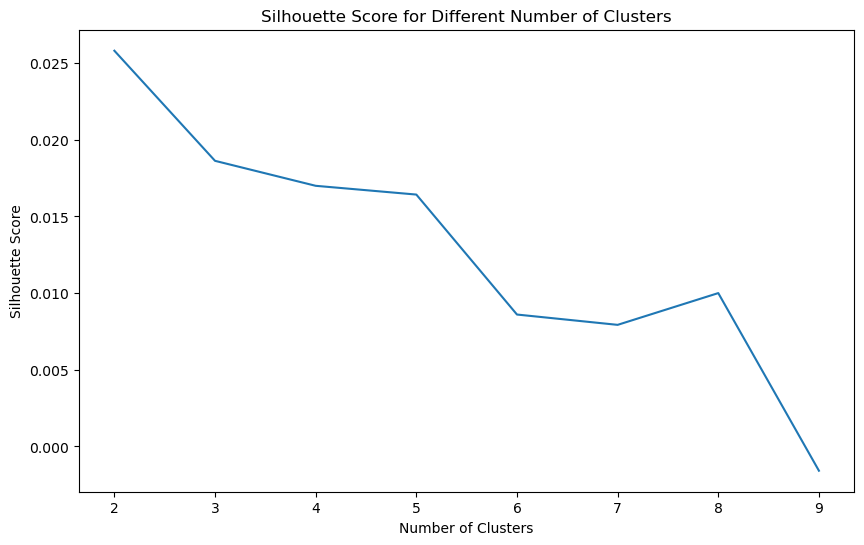

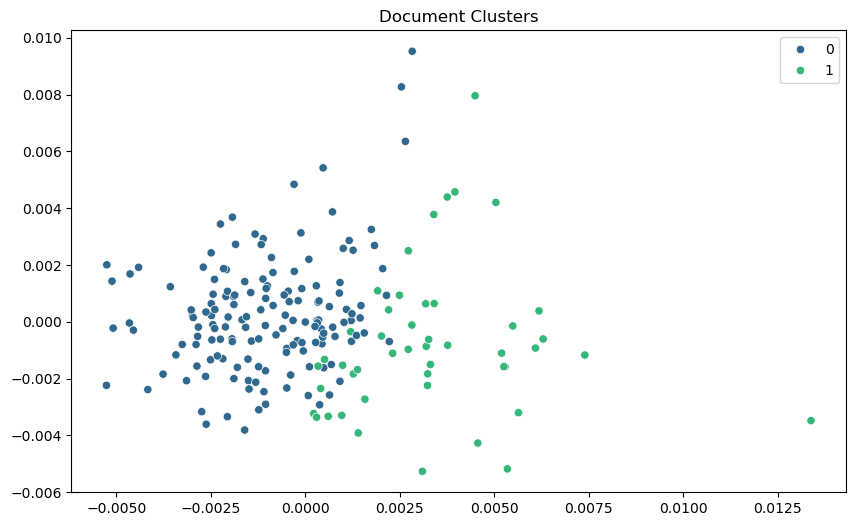

Новый документ принадлежит кластеру: 0


In [39]:
import os
import glob
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

# Загрузка стоп-слов
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(nltk.corpus.stopwords.words('english'))

def preprocess_text(text):
    # Приведение к нижнему регистру 
    text = text.lower()
    # Токенизация и удаление стоп-слов
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return filtered_tokens

def read_documents(directory):
    # Чтение всех .txt файлов из указанной директории
    file_paths = glob.glob(os.path.join(directory, '*.txt'))
    documents = []
    for file_path in file_paths:
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
            processed_text = preprocess_text(text)
            documents.append(processed_text)
    return documents

def train_word2vec(documents):
    # Обучение модели Word2Vec
    model = Word2Vec(sentences=documents, vector_size=100, window=5, min_count=1, workers=4)
    return model

def get_embeddings(documents, model):
    # Получение эмбеддингов для документов
    embeddings = []
    for doc in documents:
        doc_embedding = np.mean([model.wv[word] for word in doc if word in model.wv], axis=0)
        embeddings.append(doc_embedding)
    return np.array(embeddings)

def perform_clustering(embeddings):
    # Используем метод локтя для определения оптимального количества кластеров
    silhouette_scores = []
    for n_clusters in range(2, 10):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(embeddings)
        silhouette_avg = silhouette_score(embeddings, cluster_labels)
        silhouette_scores.append((n_clusters, silhouette_avg))
 # Визуализация Silhouette Score
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=[x[0] for x in silhouette_scores], y=[x[1] for x in silhouette_scores])
    plt.title('Silhouette Score for Different Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.show()
 # Выбираем количество кластеров с максимальным Silhouette Score 
    optimal_n_clusters = max(silhouette_scores, key=lambda x: x[1])[0]
    kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=42)
    kmeans.fit(embeddings)
 # Визуализация кластеров
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], hue=kmeans.labels_, palette='viridis')
    plt.title('Document Clusters')
    plt.show()
    
    return kmeans

def classify_new_document(new_document, model, kmeans, embeddings):
    processed_new_document = preprocess_text(new_document)
    new_embedding = np.mean([model.wv[word] for word in processed_new_document if word in model.wv], axis=0).reshape(1, -1)
    # Используем косинусное расстояние для поиска ближайшего кластера 
    neighbors = NearestNeighbors(n_neighbors=1, metric='cosine').fit(embeddings)
    distance, index = neighbors.kneighbors(new_embedding)
    nearest_cluster = kmeans.labels_[index[0][0]]
    return nearest_cluster

# Основной код
directory = '/sampled_texts'  # Укажите путь к папке с .txt файлами!!
documents = read_documents(directory)
word2vec_model = train_word2vec(documents)
embeddings = get_embeddings(documents, word2vec_model)
kmeans = perform_clustering(embeddings)

# Пример классификации нового документа
new_document = "new doc it gonna rock!"
nearest_cluster = classify_new_document(new_document, word2vec_model, kmeans, embeddings)
print(f"Новый документ принадлежит кластеру: {nearest_cluster}")
